# Solving the Traveling Salesman Problem on quantum annealers
---
When we have to travel long distances, we want to get from one place to another as quickly as possible. This challenge of precise route planning was and is faced by people long ago as well as today. But can quantum physics take this work off our hands?

This notebook is a comprehensive guide to the quantum mechanical approach to this age-old optimization problem. You will learn:
- What graphs are and how to perform calculations on them
- How QUBO problems are constructed
- How the Traveling Salesman Problem can be represented as a Hamiltonian for quantum annealers
- What the advantages and drawbacks of this method are
- How to perform pathfinding on your own graphs


### A different learning tool

<p style="text-align: center">  </p>

This course is openly accessible at [TSP Quantum](https://tsp-quantum.netlify.app/), an online learning app with interactive data visualizations. TSP Quantum is beginner-friendly and allows you to learn about quantum annealers without writing any code. Some tools and helper programs that can be downloaded there will even be referenced in this guide. Feel free to stop by!

If you're looking for further information, check out [the project's GitHub repo](https://github.com/Totemi1324/TSPquantum).

**Have fun learning!**

*Creator: Tamas Nemes (2022)*

<a href="https://github.com/Totemi1324/"><img alt="followers" title="Follow me on Github" src="https://img.shields.io/github/followers/Totemi1324?color=236ad3&style=for-the-badge&logo=github&label=Follow"/></a>

---
## Before we start

Setup the environment and install ezgraph by running these two cells:

In [ ]:
import sys, os
sys.path.append(os.path.expanduser('~/.local/lib/python' + str(sys.version_info.major) + '.' + str(sys.version_info.minor) + '/site-packages/'))

In [ ]:
%%bash
unset PYTHONNOUSERSIZE
pip install --user ezgraph==1.0.0

---
## An introduction to the Traveling Salesman Problem

You are the representative of a big company that sends you on a business trip through its main sites. Coincidentally, they are located in the eight largest cities in Germany<sup>1)</sup>. You want to save as much time and money as possible, of course. If you start from Berlin, visit each city exactly once, and then return to Berlin, in what order should you visit the cities to keep the trip as short as possible?

<div align="center" >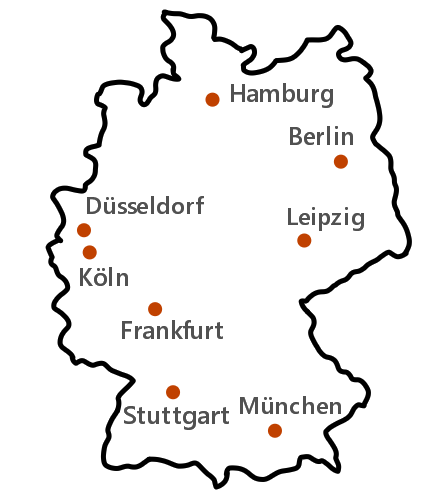</div>

That is the question addressed by the Traveling Salesman Problem. Or, put more generally:

<div align="center" style="margin-bottom: 1em"><strong>"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?"<sup>2)</sup></strong></div>

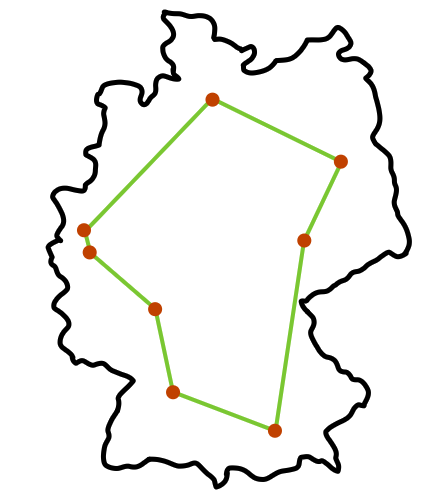

In the case of such small tasks, a solution by eye is of course possible: If beelines are taken as the measure of distance, the shortest path would be the one as shown, around the outside. But if you have to visit 20, 50, or even 100 cities, the matter is no longer so simple.

The *Traveling Salesman Problem* (or *TSP* for short) can be found in numerous real-world applications, such as supply chain design, pipeline renovation, and crystal structure analysis. Accordingly, a fast and reliable solution method is important. The catch: The number of possible paths, calculated with the formula $$S(n)=\frac{(n-1)!}{2}$$ is immense and growing at a huge pace with each added city. In our 8 cities example, we have `2520` possibilities to choose from, but with 12 cities, there are already `19.958.400` different paths. Hence, the problem is NP-hard, basically meaning that an algorithm that finds the exact solution for large inputs in a finite time is likely to be impossible.

### Why a quantum approach?

The TSP is a good example of an "optimization problem". Since we can't try all solutions without waiting for decades and can't calculate the best one definitively, we try to approximate it as best as we can. It is possible to find the *"global" optimum*, the shortest path of all, but we can just as well end up at a *"local" optimum*, one of the many shorter paths. Quantum annealers, a subset of quantum computers, are made for this task because of the physical properties of qubits. Additionally, traditional optimization algorithms are slow, whereas a quantum annealer finds its solution in mere microseconds. In this course, we will explore how the quantum annealers of D-Wave can handle the TSP and whether we can find better solutions than with traditional methods. But first, let's do some basic mathematics.

<div align="center"><img width="350" src="https://miro.medium.com/max/1400/1*emPDLzTy0oW5BWLuxDSbKQ.png"></div>
<div align="center"><i>How can we find the deepest valley when seeing just one point at a time? An example for optimization problems<sup>3)</sup></i></div>

### Graphs

Computers only take numbers, so we need to use them as well. We already subconsciously drew a key concept of the solving method with the cities interconnected with lines: *Graphs* are a fundamental part of mathematics, so much so that they have their own field of study called *graph theory*. In general, a graph describes a set of cities, called *"vertices"*, and how they are connected mathematically.

Let's simplify our example from above to just 4 cities and name them A, B, C, and D. The following code produces an interactive plot of our graph.

In [ ]:
import ezgraph.tools as ezg

# Load the coordinates of our cities
cities = ["München", "Stuttgart", "Leipzig", "Düsseldorf"]
latitudes = [48.137154, 48.783333, 51.3396955, 51.233334]
longitudes = [11.576124, 9.183333, 12.3730747, 6.783333]
cmap = {"A": "München", "B": "Stuttgart", "C": "Leipzig", "D": "Düsseldorf"}

# Produce graph data
graph = ezg.generate_graph(cities, latitudes, longitudes, cmap=cmap)

# Draw graph
ezg.draw_graph(graph, title="Fully connected graph with 4 vertices")

Every node is represented as a red circle connected to the other nodes through *"edges"*, the distances between the nodes drawn in blue. In our example, every possible pair of vertices is connected, each edge can be traversed in both directions and each edge has a unique distance value assigned to it. This is called a **complete undirected weighted graph**. Graphs can have various shapes and types, but in this tutorial, we only focus on this one since it corresponds to the standard definition of the TSP.

In mathematical terms, a graph like this can be characterized as follows:

$$G=\left(V,E,d\right)$$
where
$$V=\left\{v_1,v_2,...\right\}$$
$$E\subseteq\left\{\left\{v_i,v_j\right\}|\left(v_i,v_j\right)\in V^2\wedge v_i\neq v_j\right\}$$
$$d:E\to\mathbb{R}$$

That was quite a lot at once. Let's go through it step-by-step:
- A graph `G` is a combination of three components: `V`, the vertices, `E`, the edges, and `d`, a distance function. The notation in `()` as a triplet shows that they belong together.
- `V` denotes a set of vertices that are part of the graph. Sets are marked by curly braces `{}`.
- `E` is a set of edges, which are unordered pairs of vertices {v<sub>i</sub>, v<sub>j</sub>}. The pipe symbol `|` defines what conditions these pairs must fulfill: Both v<sub>i</sub> and v<sub>j</sub> must be part of V<sup>2</sup> ("squared" for sets means the cartesian product, i.e. the set of all possible combinations of a set's elements) **and** v<sub>i</sub> must not be equal to v<sub>j</sub> to prevent loops.
- `d` is a function that maps every edge (i.e. unordered pair of vertices) to a real number, in this case, the distance.

So, the graph above can be described like this:

$$V=\left\{A,B,C,D\right\}$$

$$E=\left\{\left\{A,B\right\},\left\{A,C\right\},\left\{A,D\right\},\left\{B,C\right\},\left\{B,D\right\},\left\{C,D\right\}\right\}$$

$$d:E\to\begin{cases}2.5 & \text{if }E=\left\{A,B\right\} \\ 3.3 & \text{if }E=\left\{A,C\right\} \\ 5.7 & \text{if }E=\left\{A,D\right\} \\ 4.1 & \text{if }E=\left\{B,C\right\} \\ 3.4 & \text{if }E=\left\{B,D\right\} \\ 5.6 & \text{if }E=\left\{C,D\right\}\end{cases}$$

The job of every TSP algorithm is to find a path that visits each vertex exactly once and returns to the starting vertex (also called a *closed Hamiltonian cycle*) where the sum of the distances from the distance function is as low as possible. Since the goal is to traverse the graph, the TSP is a "graph traversal" problem. 

## QUBO problems

Before we can explore how quantum annealers work, there is an essential basic to be covered. For a quantum annealer to solve a task, it must be defined as a **quadratic unconstrained binary optimization problem** or **QUBO problem** for short. This isn't particularly helpful, so let's break it down:

- *Quadratic* means a maximum of two variables can be multiplied.
- *Unconstrained* means the correct answer is not constrained by other conditions.
- *Binary* means we can insert 0 or 1 only.
- *Optimization* is - if you remember from earlier - the process of finding the optimal solution to a complex problem with approximation.

The QUBO form is another mathematical construct that aids the quantum annealer in utilizing the physical properties of its qubits. Let's look at an example to illustrate the concept.

> Sidenote: The following is only one possible type of QUBO problem, but since it is closest to the TSP, it is the only one covered in this course. Also, there are other ways of programming a quantum annealer, like Ising problems, which we will omit for the sake of conciseness.

<div align="center">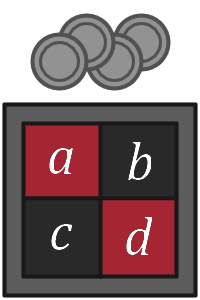</div>
<br>

This 2x2 checkers board has the four fields `a`, `b`, `c`, and `d`. Additionally, there are four pieces, each of which can, but doesn't have to be placed on any field (but not multiple on the same field). When a field is occupied, it is represented as **1**, otherwise as a **0**. The quantum computer should place the pieces so that as many fields as possible are occupied.

Again: A computer needs numbers. Is there a way to tell how good a particular solution is? All optimization problems require a **cost function**, which rates a solution's correctness: The lower the cost, the better. Now, our goal shifted from finding the best solution to minimizing the cost function. If we have a QUBO problem that takes four variables `a`, `b`, `c`, and `d` (which are either 0 or 1) as an input, the cost function is defined as follows:

$$f\left(a,b,c,d\right)=h_aa+h_bb+h_cc+h_dd+h_{ab}ab+h_{ac}ac+h_{ad}ad+h_{bc}bc+h_{bd}bd+h_{cd}cd$$

First, we sum up the values of all fields, then we add the product of each possible *pair* of the field values. The `h` with which the field values are multiplied are simple coefficients, i.e. real numbers, that control how much we want to reward (or punish) the individual occupancies. This is quite a clever system: If a field is unoccupied, meaning 0, it eliminates the corresponding coefficient from the equation. Similarly, in the pairs of fields, a reward only stays in the equation if both fields are 1. Since we are searching for the lowest cost, `h < 0` means "reward", `h > 0` "punishment" and `h = 0` "irrelevant". For example: If we really want `a` to be occupied, we can give it an `h` of -10, or if we want to prevent that `b` and `c` are occupied simultaneously, `h` should be a high positive number like 25.

Now we can define a QUBO problem for our original task: As many fields as possible should be occupied.

$$f\left(a,b,c,d\right)=(-1)\times a+(-1)\times b+(-1)\times c+(-1)\times d=-a-b-c-d$$

We can omit to calculate the pairs of field values since the relations between fields are irrelevant for this problem. This is a valid cost function because the lowest cost, -4, is only reached if all fields are 1. Let's add the following condition to our task: Fields `a` and `b` can **not** be occupied at the same time.

$$f\left(a,b,c,d\right)=-a-b-c-d+4ab$$

If `a` and `b` are both 1, even if all fields are occupied for maximum reward, the cost is 0, meaning it's worse than all the other possible solutions. Hence, the best cost achievable here is -3, displaying the correct solution. Another practical strategy in QUBO problems is *squaring*, for instance for the task "Exactly <ins>two out of four</ins> fields should be occupied":

$$f\left(a,b,c,d\right)=\left(a+b+c+d-2\right)^2$$
$$=a^2+2ab+2ac+2ad-4a+b^2+2bc+2bd-4b+c^2+2cd-4c+d^2-4d+4$$
$$=-3a-3b-3c-3d+2ab+2ac+2ad+2bc+2bd+2cd$$

This works because when summing up all fields and subtracting 2, the result is only 0 if exactly two fields are 1. But: If no field or one field is occupied, the result would be negative, giving an even better result. This can be fixed by squaring the equation because squaring a negative number will result in a positive value. The squared field values like a<sup>2</sup>, b<sup>2</sup>, etc. that result from multiplying the equation out would be illegal (i.e. against the rules of QUBO), but since in the case of binary numbers x<sup>2</sup>=x, they can be replaced with a, b, etc. Also, constants like +4 can be omitted as well, because they just shift all results up or down by the same amount. We can check if our cost function works by testing it with different inputs:

$$f\left(0, 1, 0, 0\right)=-3$$
$$f\left(1, 0, 1, 0\right)=-4$$
$$f\left(0, 1, 1, 1\right)=-3$$
$$f\left(1, 1, 1, 1\right)=0$$

### Code-it-yourself: Formulate the QUBO equation

Held out until here? Great! You can practice formulating QUBO equations on the following exercises from easy to hard. Execute the code block and enter your answer in the boxes. Execute the second code block to check your answer. You can also view the solution if you're stuck.

<i>As many fields as possible should be empty.</i>

In [ ]:
import ipywidgets as widgets

# Display widgets
print("Enter the coefficients of your solution in the format described above.")

labels = ["a", "b", "c", "d", "ab", "ac", "ad", "bc", "bd", "cd"]
w = [widgets.FloatText(value=0,description=labels[i],disabled=False,layout=widgets.Layout(flex='1 1 auto', width='auto')) for i in range(10)]

display(widgets.HBox(w, layout=widgets.Layout(flex_flow='row wrap')))

In [ ]:
import json, requests
import IPython.display as idisplay

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
for solution in data["ciy_0_qubo_solutions"]:
    if solution["id"] == 0:
        # Get widget values
        vals = [item.value for item in w]
        # Check solution
        if vals == solution["solution"]:
            print("Your solution is correct! Hooray 🎉")
            idisplay.display(idisplay.Math(solution["display"]))
        else:
            print("Your solution is incorrect. Check for typos or try again.")
            answer = input("Do you want to view the solution? (y/n)").lower()
            if answer == "y" or answer == "yes":
                print("\nCorrect solution:")
                idisplay.display(idisplay.Math(solution["display"]))

<i>There should be <ins>no more than one</ins> field occupied. (i.e.: Exactly zero fields or one field should be occupied.)</i>

In [ ]:
import ipywidgets as widgets

# Display widgets
print("Enter the coefficients of your solution in the format described above.")

labels = ["a", "b", "c", "d", "ab", "ac", "ad", "bc", "bd", "cd"]
w = [widgets.FloatText(value=0,description=labels[i],disabled=False,layout=widgets.Layout(flex='1 1 auto', width='auto')) for i in range(10)]

display(widgets.HBox(w, layout=widgets.Layout(flex_flow='row wrap')))

In [ ]:
import json, requests
import IPython.display as idisplay

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
for solution in data["ciy_0_qubo_solutions"]:
    if solution["id"] == 1:
        # Get widget values
        vals = [item.value for item in w]
        # Check solution
        if vals == solution["solution"]:
            print("Your solution is correct! Hooray 🎉")
            idisplay.display(idisplay.Math(solution["display"]))
        else:
            print("Your solution is incorrect. Check for typos or try again.")
            answer = input("Do you want to view the solution? (y/n)").lower()
            if answer == "y" or answer == "yes":
                print("\nCorrect solution:")
                idisplay.display(idisplay.Math(solution["display"]))

<i>In every row and every column, <ins>exactly one</ins> field should be occupied.</i>

In [ ]:
import ipywidgets as widgets

# Display widgets
print("Enter the coefficients of your solution in the format described above.")

labels = ["a", "b", "c", "d", "ab", "ac", "ad", "bc", "bd", "cd"]
w = [widgets.FloatText(value=0,description=labels[i],disabled=False,layout=widgets.Layout(flex='1 1 auto', width='auto')) for i in range(10)]

display(widgets.HBox(w, layout=widgets.Layout(flex_flow='row wrap')))

In [ ]:
import json, requests
import IPython.display as idisplay

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
for solution in data["ciy_0_qubo_solutions"]:
    if solution["id"] == 2:
        # Get widget values
        vals = [item.value for item in w]
        # Check solution
        if vals == solution["solution"]:
            print("Your solution is correct! Hooray 🎉")
            idisplay.display(idisplay.Math(solution["display"]))
        else:
            print("Your solution is incorrect. Check for typos or try again.")
            answer = input("Do you want to view the solution? (y/n)").lower()
            if answer == "y" or answer == "yes":
                print("\nCorrect solution:")
                idisplay.display(idisplay.Math(solution["display"]))

## How do quantum annealers work?

Equipped with this basic knowledge, we can now face the question: How do we get from an input to a result? The process of programming a quantum annealer differs greatly from that of a traditional computer since it takes numbers rather than instructions or lines of code. Here is a depiction of this procedure:

<div align="center">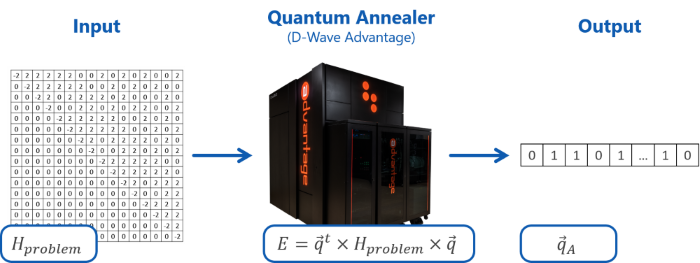</div>

This may look a bit confusing, so let's tackle it step-by-step.

### Vectors and matrices

To represent our data, we need yet another mathematical construct. In its traditional form, a *vector* is a quantity in space with a direction and length (often represented as an arrow or ray)<sup>4)</sup> and consists of two or more coordinates written in a vertical column. For example, a vector in 3-dimensional space would contain three coordinates:

$$\vec{ q }=\begin{pmatrix}q_1 \\ q_2 \\ q_3\end{pmatrix}$$

$$\vec{q}\in\mathbb{R}^3$$

As a vector holds an array of numbers, we can utilize vectors to retrieve our results from the quantum annealer. If we had a 4x4 checkers board with 4<sup>2</sup>=16 fields, the entries would denote whether our fields `a`, `b`, etc. through `n` should be occupied (1) or not (0). This is defined as the <strong>answer vector q<sub>A</sub></strong>.

$$\vec{q}_A = \begin{pmatrix}a \\ b \\ \vdots \\ n\end{pmatrix} = \begin{pmatrix}0 \\ 1 \\ \vdots \\ 1\end{pmatrix}$$

Similarly, think of a *matrix* as a series of vectors glued together. It is a rectangular field of numbers where `m` denotes the number of rows and `n` the number of columns (containing `m x n` elements) and `i` and `j` the row and column index of a given element.

$$M=\begin{pmatrix}a_{11} & \cdots & a_{1j} & \cdots & a_{1n} \\ \vdots & \ddots & \vdots & \ddots & \vdots \\ a_{i1} & \cdots & a_{ij} & \cdots & a_{in} \\ \vdots & \ddots & \vdots & \ddots & \vdots \\ a_{m1} & \cdots & a_{mj} & \cdots & a_{mn} \end{pmatrix}$$

For example, the element a<sub>31</sub> of the matrix A below is 5.

$$A=\begin{pmatrix}1 & 4 & 2 & 1 \\ 3 & 0 & 3 & 1 \\ \mathbf{5} & 1 & 2 & 0 \\ 4 & 1 & 2 & 3\end{pmatrix}$$

Don't worry if it is not fully clear yet, we will use matrices only as a simple means to an end. Remember the QUBO equations from the previous section? In fact, matrices are the only way to pass those as an input to the quantum annealer. Since the form of QUBO equations is always the same, we can concatenate the coefficients (the only values that change) in a matrix of the following format to create a representation of our problem's definition:

$$f\left(a,b,c,d\right)=h_aa+h_bb+h_cc+h_dd+h_{ab}ab+h_{ac}ac+h_{ad}ad+h_{bc}bc+h_{bd}bd+h_{cd}cd$$

$$\Rightarrow H=\begin{pmatrix}h_a & h_{ab} & h_{ac} & h_{ad} \\ 0 & h_b & h_{bc} & h_{bd} \\ 0 & 0 & h_c & h_{cd} \\ 0 & 0 & 0 & h_d\end{pmatrix}$$

This is the definition of the **Hamilton matrix H**, or just **Hamiltonian**. In its main diagonal (the fields where `i` and `j` are equal) are the coefficients of the individual fields and next to them those of the connections to other fields. Because the lower half remains empty and is filled with zeros, the Hamiltonian belongs to the type of *upper triangular matrices*. If we take our "checkers" example from the previous section with the QUBO problem "Exactly two out of four fields should be occupied", this is the resulting Hamiltonian:

$$H=\begin{pmatrix}-3 & 2 & 2 & 2 \\ 0 & -3 & 2 & 2 \\ 0 & 0 & -3 & 2 \\ 0 & 0 & 0 & -3\end{pmatrix}$$

Now, we said that a quantum annealer tries to find the answer vector whose coordinates give the lowest cost. Since we compressed the cost function, which was our QUBO problem, into a matrix, the operation can be reformulated as follows<sup>5)</sup>:

$$\min C\left(q\right)=\min_{q_i=0,1}\left(\sum_{i=1}^{N}a_iq_i+\sum_{i<j}^{N}b_{ij}q_iq_j\right)=\min\left(\vec{q}^TH\vec{q}\right)$$

This looks more complicated than it is and just tells us that we want to minimize the cost `C` which consists of two sums, namely the products of each coefficient a<sub>i</sub> with its respective field q<sub>i</sub> and the other coefficients b<sub>ij</sub> with any pair of two fields q<sub>i</sub> and q<sub>j</sub>. Alternatively, we can consider the operation as a matrix multiplication, where the Hamiltonian is multiplied from the right with the answer vector and from the left with the transformed (i.e. horizontal) answer vector.

<div align="center"><strong>Congratulations! You now understand how a quantum annealer solves problems.</strong></div>

### The inner workings

But how does a quantum annealer work on the inside? This is a more complicated subject, which we can only treat superficially here without having advanced knowledge of quantum physics.

<img align="right" width="150" src="https://theme.zdassets.com/theme_assets/2189494/2d45caf29d00fd8235e4abaf192bad5d8cc3d01b.png">

The heart of a quantum annealer is the *QPU* (Quantum Processing Unit, image taken from <sup>6)</sup>), a few square centimeters large chip, which is equipped with the quantum mechanical counterparts of the bits, *qubit*s. In contrast to classical computers, these are not realized with transistors but with artificial atoms of a certain spin, which allows them to assume two states simultaneously (*spin up* and *spin down*) according to the rules of quantum physics until they are measured. The quantum annealer derives its potentially enormous computing power from this state called *superposition*.

The current model *D-Wave Advantage* has exactly 5627 qubits. These are interconnected with so-called *couplers*, which allow the qubits to interact with each other. The number of couplers per qubit ultimately determines the computing power of the annealer.

<div align="center"><br><br><img width="600" src="https://www.researchgate.net/profile/Carlos-Gonzalez-Calaza/publication/348802801/figure/fig2/AS:984433192624130@1611718571797/Graphs-of-Chimera-and-Pegasus-topologies-where-nodes-and-edges-represent-qubits-and.png"><br><i>The graphs of the (a) Chimera architecture of the D-Wave 2000Q and the newer (b) Pegasus architecture show the differences between the QPU's structures. (a) has 6 couplers/qubit, (b) 15 couplers/qubit<sup>7)</sup></i></div>
<br>

These couplers consist of magnetic fields that can be tweaked individually, so that after a measurement, a qubit is more likely to become `1` or `0`, respectively, and pairs of qubits are more likely to assume equal or unequal values. When the quantum annealer receives a Hamiltonian, it sets the coefficients a<sub>i</sub> and b<sub>ij</sub> as the strength of these magnetic fields also called *bias*. For the annealer to work, the QPU must be cooled to a temperature near absolute zero (16mK, approx. -273.1°C). Through an effect known as *quantum tunneling*, the qubits in this system try to anneal the state of the lowest energy, which, through the programming of the couplers, is the best solution for the original optimization problem. That is the reason why a cost function is needed: It determines the state of "lowest cost" (or "lowest energy").

### The D-Wave Ocean SDK

The easiest way to interact with the D-Wave quantum annealers is the Ocean SDK, a Python library already installed in this notebook. Look at the following basic example and execute the cells in order to learn the fundamentals of quantum computing with Ocean. You can find further information on the [dwave-system Official Documentation](https://docs.ocean.dwavesys.com/projects/system/en/stable/index.html)<sup>8)</sup>.

To import the most important components, type:

In [ ]:
import dwave
import dwave.inspector
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client

Now, we can send the quantum annealer a QUBO problem to solve, but in the form of a dictionary instead of a Hamilton matrix. A dictionary is a data structure that pairs values (*keys*) with other values, in our case the position in the Hamiltonian `(row, column)` (Watch out: Counting begins at zero!) with the corresponding coefficient value. This way, the masses of zeros in the Hamiltonian, which would otherwise have consumed a lot of unnecessary memory, can be omitted.

Next, we create a *sampler*, a sort of configuration that we can request results from. The `EmbeddingComposite` command automatically generates a layout of qubits and couplers that our problem will use, so we don't need to declare them manually.

In [ ]:
# Example QUBO problem; print to visualize
qubo = {
    (0,0): -1,
    (1,1): -0.5,
    (0,1): 2,
}
print(qubo)

sampler = EmbeddingComposite(DWaveSampler(profile='defaults'))

We can now post a request to our sampler to get, in this case, `num_reads=100` results from the quantum annealer. This request is placed in a queue the annealer works on constantly. The problem's status, processing time, and more can be reviewed in your DWave Leap dashboard. 

In [ ]:
results = sampler.sample_qubo(qubo, num_reads=100)
print(results)

When the program is finished, we can either visualize the results as a table or save them in a separate file.

In [ ]:
# Table using pandas
import pandas as pd
results.to_pandas_dataframe()

# Save results in file
f = open("results.txt", "w")
for sample, energy, num_occurrences, cbf in results.record:
    f.write('%f\t%g\t%d\t%s\n' % (energy, cbf, num_occurrences, sample))
f.close()

You can also view the results as an interactive graphic plot as well as an embedding visualization in the D-Wave Inspector.
> Note: In the current version of JupyterLab, this code does not work due to a bug. The developers are working on a fix soon!

In [ ]:
# TODO: Does not work yet
dwave.inspector.show(results)

### Code-it-yourself: Solve your own QUBO problem with Ocean SDK

You are now ready to solve a real mathematical problem using the D-Wave quantum annealer! If you want to practice QUBO equations, Hamiltonians and the usage of D-Wave Ocean on your own, create a solution for the following puzzle:

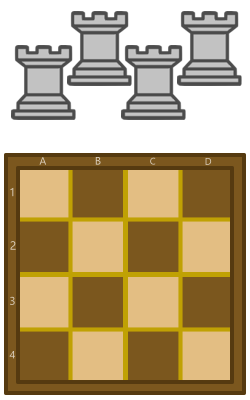

Imagine a 4x4 chessboard with four rooks of one color. These can be placed according to the rules of classical chess:
1. No more than one rook can be on the same field
2. Only one rook per row is allowed
3. Only one rook per column is allowed

In what configuration(s) can you place the rooks so that no two rooks threaten each other? (This is a variation of the famous mathematical problem *n-rooks problem*).

**Happy coding!**

*1. Take a piece of paper and create a valid Hamiltonian for the 4-rooks-problem! How can you transfer the placement rules to a QUBO problem?*

To view the correct solution, execute the code block below:

In [ ]:
import json, requests
import IPython.display as idisplay

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
solutions = data["ciy_1_solutions"]

answer = input("Do you really want to view the solution? (y/n)").lower()
if answer == "y" or answer == "yes":
    print(solutions["solution_texts"][0])
    for eq in solutions["qubo_display"]:
        idisplay.display(idisplay.Math(eq))
    print(solutions["solution_texts"][1])
    print(solutions["matrix_display"])

*2. Now, the correct Hamiltonian is loaded automatically. Using the tutorial in the previous section, complete the code below to send the matrix to the quantum annealer!*

In [ ]:
# Helper code to read Hamiltonians from files with numpy and convert them to a dictionary
# =================================================================
import dwave
import dwave.inspector
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client
import numpy as np
import json, requests

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
qubomatrix = np.asarray(data["ciy_1_solutions"]["matrix"])

qubo = {(i, i): 0.0 for i in range(len(qubomatrix))}
for index, value in np.ndenumerate(qubomatrix):
    if value != 0:
        qubo[index] = value
print('Converted matrix into QUBO for D-Wave:\n', qubo, '\n')
# =================================================================

# ENTER YOUR CODE HERE...

Execute this code block for the solution if you are stuck:

In [ ]:
import json, requests

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
solutions = data["ciy_1_solutions"]

answer = input("Do you really want to view the solution? (y/n)").lower()
if answer == "y" or answer == "yes":
    print(solutions["solution_texts"][2] + "\n")
    print(solutions["solution_code"])

## Transforming the Traveling Salesman Problem for quantum annealers

Now, we have arrived at the main part of the course. Creating a quantum solution for the TSP is an exciting example of the versatility of quantum computing as well as a demonstration of how it can help improve everyday tasks. The first step towards such a method is the question of how to transform the core component of the TSP, the graph, into a QUBO problem.

As shown in the previous sections, the easiest way of creating QUBO problems is through a square field with numbered cells. Let's consider the simplest instance of the TSP, a graph of four cities (since this is the minimum number of vertices that allows different solutions than the optimum):

In [ ]:
import ezgraph.tools as ezg

cities = ["Köln", "Berlin", "Leipzig", "Hamburg"]
latitudes = [50.935173, 52.520008, 51.3396955, 53.551085]
longitudes = [6.953101, 13.404954, 12.3730747, 9.993682]
cmap = {"A": "Köln", "B": "Berlin", "C": "Leipzig", "D": "Hamburg"}
tour = ["A", "B", "D", "C", "A"]

graph = ezg.generate_graph(cities, latitudes, longitudes, cmap=cmap, tour=tour)
ezg.draw_graph(graph, title="An example TSP of n=4 with a possible solution")

If we consider `A` as a starting point, here our tour is **A -> B -> D -> C -> A** (of course, the inverse A -> C -> D -> B -> A is valid, too). How can we transform this data structure to a number field?

### The Tour Matrix

A possible tour is characterized by two parts of information:

1. The chronological order of the visited cities
2. The total cost of the route, i.e. the sum of the length of the edges taken

By using a matrix, the mathematical concept previously discussed, it is possible to address the first point. Applied to the graph above, the result is this:

In [ ]:
import numpy as np
import pandas as pd

data = np.array([['', '1', '2', '3', '4'], ['A', 1, 0, 0, 0], ['B', 0, 1, 0, 0], ['C', 0, 0, 0, 1], ['D', 0, 0, 1, 0]])
df = pd.DataFrame(data=data[1:, 1:], index=data[1:, 0], columns=data[0, 1:])
df

The rows represent the individual cities, while the columns mark the "points in time", i.e. each step made. An entry of `1` in the field a<sub>ij</sub> means that the `i`-th city is visited in the `j`-th time step. The fifth time step would mark the return to the starting city, but since it would always be an exact copy of the first column, it can be omitted to minimize the data. Now, we have created an abstraction that can be applied to tours in graphs of any size. Let's name this new structure *tour matrix*.

Perhaps, you can already see where this is going: Indeed, this looks very similar to the "checkers" example from Section 2. You can think of the `1`s as the pieces that can be placed on a board to mark which city belongs to which time step. So next, we're going to explore how to extract the QUBO equation.

## Formulating the QUBO equation

From the example tour matrix above, the following rules for occupancy can be derived:

1. Exactly one occupation per row is allowed (since it is not possible to visit a city more than once)
2. Exactly one occupation per column is allowed (since it is not possible to visit multiple cities at the same time)

In this 4x4 grid, the cells are named in alphabetical order. For four cities, the QUBO equation is formulated as follows:

<div align="center">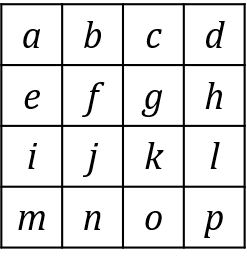</div>

$$f\left(a,...,p\right)=\left(a+b+c+d-1\right)^2+\left(e+f+g+h-1\right)^2+\left(i+j+k+l-1\right)^2+\left(m+n+o+p-1\right)^2$$
$$+ \left(a+e+i+m-1\right)^2+\left(b+f+j+n-1\right)^2+\left(c+g+k+o-1\right)^2+\left(d+h+l+p-1\right)^2$$
$$=-2a+2ab+2ac+2ad+2ae+2ai+2am-2b+2bc+2bd+2bf+2bj+2bn-2c+2cd+2cg+2ck+2co$$
$$-2d+2dh+2dl+2dp-2e+2ef+2eg+2eh+2ei+2em-2f+2fg+2fh+2fj+2fn-2g+2gh+2gk+2go$$
$$-2h+2hl+2hp-2i+2ij+2ik+2il+2im-2j+2jk+2jl+2jn-2k+2kl+2ko-2l+2lp-2m+2mn+2mo+2mp$$
$$-2n+2no+2np-2o+2op-2p+8$$

This is a massive and unhandy equation, but a valid cost function since only the correct occupations yield the lowest cost. Since it depends on the number of cities *n*, the QUBO equation takes <i>n<sup>2</sup></i> variables as its input (meaning it grows at a quadratic rate) and must be reformulated for every individual TSP instance. Here is a piece of code that makes this process easier:

In [ ]:
# Get number of cities
n = int(input("Number of cities:"))
field = [["" for x in range(n)] for y in range(n)]
counter = 1
for i in range(len(field)):
    for j in range(len(field[i])):
        field[i][j] = "q_{"+str(counter)+"}"
        counter += 1

equation = ""
# Fill out equation
for i in range(len(field)):
    for j in range(len(field[i])):
        equation += "-2"+field[i][j]
        for k in field[i][j+1:]:
            equation += "+2"+field[i][j]+k
        for k in range(len(field)):
            if k > i: equation += "+2"+field[i][j]+field[k][j]

# Print equation
print("\nQUBO equation in LaTeX format:\n{0}".format(equation))

But this is only half of the story. In order to quantify the second key information of the tours, the route cost must also be considered in the QUBO equation. Luckily, since it is a cost function as well, the values can be adopted and added to the total cost as is. But how to determine which ones to add and when? Consider the following example:

<div align="center">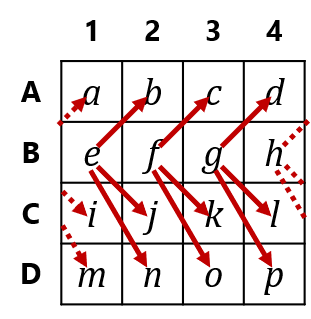</div>

A given edge is taken if its initial vertex is marked in one column and its destination vertex in the following column. Here, the arrows denote all edges that go from `B` to the other vertices. Since we initially don't know when we're going to visit `B`, this has to be repeated for all time steps. For example, the edge <span style="text-decoration: overline">BA</span> with the cost of 6.6 is corresponding with `(e, b)`, `(f, c)`, `(g, d)`, and `(h, a)`. If we multiply this cost with those pairs of variables (this is compliant with the rules of QUBO problems), it is only added if both fields are visited, i.e. equal to `1`. Additionally, there is no danger of adding the cost of a specific edge more than once because, since it is forbidden to visit a city more than once, only one of these four cases will ever occur, if any. So this is what the second half of the QUBO equation looks like:

$$6.6af+6.6bg+6.6ch+6.6de+5.4aj+5.4bk+5.4cl+5.4di+4.0an+4.0bo+4.0cp+4.0dm+6.6eb+6.6fc$$
$$+6.6gd+6.6ha+1.6ej+1.6fk+1.6gl+1.6hi+3.6en+3.6fo+3.6gp+3.6hm+5.4ib+5.4jc+5.4kd+5.4la$$
$$+1.6if+1.6jg+1.6kh+1.6le+3.2in+3.2jo+3.2kp+3.2lm+4.0mb+4.0nc+4.0od+4.0pa+3.6mf+3.6ng$$
$$+3.6oh+3.6pe+3.2mj+3.2nk+3.2ol+3.2pi$$

This part just gets added to the rest of the equation and must also be re-generated for every TSP instance. Now, this cost function will yield the best (lowest) energy if the formal rules of occupancy, i.e. 1/row and 1/column are satisfied *and* the quantum annealer chooses those connections whose sum is minimal, according to the TSP requirements (keep this statement in mind; we will discuss in the next section why this isn't that simple).

<div align="center"><strong>We've successfully turned the Traveling Salesman problem into an annealer-compatible QUBO problem!</strong></div>

## From coefficients to the Hamiltonian

It's time to assemble: As discussed in Section 3, the coefficients from the QUBO equation need to be transferred to the Hamiltonian in order to be a valid input for the quantum annealer. The result of our calculations is a pretty massive matrix of the size 16x16 from which an excerpt is shown below:

$$H=\begin{bmatrix}h_a & h_{ab} & h_{ac} & h_{ad} & h_{ae} & h_{af} & h_{ag} & h_{ah} & \cdots & h_{ap} \\ 0 & h_{b} & h_{bc} & h_{bd} & h_{be} & h_{bf} & h_{bg} & h_{bh} & \cdots & h_{bp} \\ 0 & 0 & h_{c} & h_{cd} & h_{ce} & h_{cf} & h_{cg} & h_{ch} & \cdots & h_{cp} \\ 0 & 0 & 0 & h_{d} & h_{de} & h_{df} & h_{dg} & h_{dh} & \cdots & h_{dp} \\ 0 & 0 & 0 & 0 & h_{e} & h_{ef} & h_{eg} & h_{eh} & \cdots & h_{ep} \\ 0 & 0 & 0 & 0 & 0 & h_{f} & h_{fg} & h_{fh} & \cdots & h_{fp} \\ 0 & 0 & 0 & 0 & 0 & 0 & h_{g} & h_{gh} & \cdots & h_{gp} \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & h_{h} & \cdots & h_{hp} \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & h_{p}\end{bmatrix}=\begin{bmatrix}-2 & 2 & 2 & 2 & 2 & 6.6 & 0 & 6.6 & \cdots & 4 \\ 0 & -2 & 2 & 2 & 6.6 & 2 & 6.6 & 0 & \cdots & 0 \\ 0 & 0 & -2 & 2 & 0 & 6.6 & 2 & 6.6 & \cdots & 4 \\ 0 & 0 & 0 & -2 & 6.6 & 0 & 6.6 & 2 & \cdots & 2 \\ 0 & 0 & 0 & 0 & -2 & 2 & 2 & 2 & \cdots & 3.6 \\ 0 & 0 & 0 & 0 & 0 & -2 & 2 & 2 & \cdots & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -2 & 2 & \cdots & 3.6 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -2 & \cdots & 2 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & -2\end{bmatrix}$$

So the problem is solved, right? Unfortunately, not quite. There is one issue left we have to talk about: the scaling. Observe what happens when we try to send this Hamiltonian to the quantum annealer:

In [ ]:
import json, requests
import numpy as np
import pandas as pd
import dwave
from dwave.system import DWaveSampler, EmbeddingComposite

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
qubomatrix = np.array(data["example_hamiltonians"][0]["matrix"])

qubo = {(i, i): 0.0 for i in range(len(qubomatrix))}
for index, value in np.ndenumerate(qubomatrix):
    if value != 0:
        qubo[index] = value
sampler = EmbeddingComposite(DWaveSampler(profile='defaults'))
results = sampler.sample_qubo(qubo, num_reads=500)
results.to_pandas_dataframe().head(5)

The Pandas table shows the top 5 from the results of the D-Wave annealer (which are sorted from best to worst). A good portion, if not all of them visit only three or even less cities. This is because the coefficients that enforce the annealer to follow the rule "Exactly one occupation per row/column" are -2 or 2 and therefore too small compared to the distances between the vertices that range from 3 to 7. If the annealer occupies less cells, the energy it saves by omitting edges far outweighs the punishment it receives for visiting less cities. To fix this problem, we have to scale our coefficients accordingly: If we multiply all coefficients by the same factor, the relations are preserved, which means that we can scale certain parts of the equation to emphasize them more. As a general rule of thumb, if `s` = the length of the longest possible tour in the graph and `n` = the number of cities, all coefficients that enforce the first rule should be calculated as follows:

$$c = \pm \frac{3s}{n}$$

Now, our Hamiltonian solves the TSP correctly for all sizes! Here is a visualization of the Hamilton matrix for a big TSP with `n = 8`:

In [ ]:
from matplotlib import pyplot as plt
import json, requests
import numpy as np

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
qubomatrix = np.array(data["example_hamiltonians"][1]["matrix"])

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1)
cax = ax.matshow(qubomatrix, cmap="cividis", interpolation="none")
ax.set_title(data["example_hamiltonians"][1]["title"])
fig.colorbar(cax)
plt.show(fig)

### How to evaluate the results

The updated Hamiltonian of the previous `n = 4` example now yields the following solution:

$$q_A=\left[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0\right]\Rightarrow\begin{bmatrix}0 & 0 & 0 & 1 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0\end{bmatrix}$$

Now we have to reverse-engineer the tour on the graph: The answer vector <i>q<sub>A</sub></i> (which contains the values of the variables `a` through `n`) first has to be translated to the tour matrix by transferring the values one-by-one to a 4x4 grid. By attaching the timestep and city labels of the tour matrix, the order of the visited cities becomes visible: **D -> B -> C -> A (-> D)**. Let's look at the graph again: Indeed, it found the shortest path!

In [ ]:
import ezgraph.tools as ezg

cities = ["Köln", "Berlin", "Leipzig", "Hamburg"]
latitudes = [50.935173, 52.520008, 51.3396955, 53.551085]
longitudes = [6.953101, 13.404954, 12.3730747, 9.993682]
cmap = {"A": "Köln", "B": "Berlin", "C": "Leipzig", "D": "Hamburg"}
tour = ["D", "B", "C", "A", "D"]

graph = ezg.generate_graph(cities, latitudes, longitudes, cmap=cmap, tour=tour)
ezg.draw_graph(graph, title="An example TSP of n=4 with the correct solution")

### Code-it-yourself: Evaluate some real TSP problems!

Of course, small problem sizes like this are not really exciting; It's time to take on some major ones! Now that you successfully completed this course, there is some room below to experiment with bigger or even self-designed TSPs. Complete the code below to test your knowledge and find some solutions using the D-Wave quantum annealer for the example TSPs provided. Also, try to experiment with the hyperparameters `chain_strength` and `annealing_time` (refer to the [D-Wave Ocean Glossary](https://docs.ocean.dwavesys.com/en/stable/concepts/index.html) or the [Reference Documentation](https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/generated/dwave.system.composites.EmbeddingComposite.sample.html#dwave.system.composites.EmbeddingComposite.sample) for a full explanation of what they do):

```
results = sampler.sample_qubo(qubo, num_reads=100, chain_strength=2, annealing_time=10)
```

Analyze the results in context of the problem size. What can you observe?

> Note: If you want to test your solution method on your own graphs, see the section below *"Insert: How to design your own graphs"* for detailed instructions. It is not recommended to submit TSPs larger than `n = 8` to the quantum annealer (see the section *"Where are the constraints?"* for more information).

**Happy experimenting!**

*The five largest European capitals:*

In [ ]:
import json, requests
import numpy as np

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
qubomatrix = np.array(data["ciy_2_hamiltonians"][0]["matrix"])

# INSERT YOUR CODE HERE...

In [ ]:
import ezgraph.tools as ezg

cities = ["London", "Berlin", "Madrid", "Rome", "Bucharest"]
longitudes = [51.507222, 52.516667, 40.383333, 41.902782, 44.432503]
latitudes = [0.127543, 13.383333, -3.716667, 12.496366, 26.103889]
cmap = {}
# Uncomment line below to enable letter labels
# cmap = {"A": "London", "B": "Berlin", "C": "Madrid", "D": "Rome", "E": "Bucharest"}
tour = []  # ENTER YOUR TOUR HERE...

graph = ezg.generate_graph(cities, latitudes, longitudes, cmap={}, tour=tour, scale=0.2)
ezg.draw_graph(graph, title=data["ciy_2_hamiltonians"][0]["title"])

*The six McDonalds restaurants in downtown London:*

In [ ]:
import json, requests
import numpy as np

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
qubomatrix = np.array(data["ciy_2_hamiltonians"][1]["matrix"])

# INSERT YOUR CODE HERE...

In [ ]:
import ezgraph.tools as ezg

cities = ["McD Oxford Circus", "McD Tottenham Court", "McD Shaftesbury Ave", "McD Picadilly Circus", "McD Leicester Square", "McD Saint Pauls"]
longitudes = [51.514798, 51.516509, 51.513692, 51.511083, 51.510203, 51.513676]
latitudes = [-0.143975, -0.130888, -0.129113, -0.133903, -0.130910, -0.100939]
cmap = {}
# Uncomment line below to enable letter labels
# cmap = {"A": "McD Oxford Circus", "B": "McD Tottenham Court", "C": "McD Shaftesbury Ave", "D": "McD Picadilly Circus", "E": "McD Leicester Square", "F": "McD Saint Pauls"}
tour = []  # ENTER YOUR TOUR HERE..

graph = ezg.generate_graph(cities, latitudes, longitudes, cmap={}, tour=tour, scale=100)
ezg.draw_graph(graph, title=data["ciy_2_hamiltonians"][1]["title"])

*The eight best known tourist attractions in the USA:*

In [ ]:
import json, requests
import numpy as np

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
qubomatrix = np.array(data["ciy_2_hamiltonians"][2]["matrix"])

# INSERT YOUR CODE HERE...

In [ ]:
import ezgraph.tools as ezg

cities = ["Statue of Liberty", "Grand Canyon", "Las Vegas Strip", "Yellowstone", "Mount Rushmore", "Golden Gate Bridge", "White House", "Niagara Falls"]
longitudes = [40.689208, 36.099623, 36.114328, 44.426757, 43.878967, 37.819928, 38.897669, 43.082463]
latitudes = [-74.044489, -112.112484, -115.172970, -110.588339, -103.459082, -122.478566, -77.0365326, -79.074260]
cmap = {}
# Uncomment line below to enable letter labels
# cmap = {"A": "Statue of Liberty", "B": "Grand Canyon", "C": "Las Vegas Strip", "D": "Yellowstone", "E": "Mount Rushmore", "F": "Golden Gate Bridge", "G": "White House", "H": "Niagara Falls"}
tour = []  # Enter your tour here

graph = ezg.generate_graph(cities, latitudes, longitudes, cmap=cmap, tour=tour, scale=0.1)
ezg.draw_graph(graph, title=data["ciy_2_hamiltonians"][2]["title"])

*Your own graph (see "Insert: How to design your own graphs" for instructions):*

In [ ]:
import dwave
from dwave.system import DWaveSampler, EmbeddingComposite
import numpy as np

qubomatrix = np.loadtxt('YOUR_FILE.txt')

# INSERT YOUR CODE HERE...

# Save your results in .txt format
results = ...

with open('YOUR_RESULTS_FILE.txt', 'w') as file:
    for sample, energy, num_occurrences, cbf in results.record:
        file.write('%f\t%g\t%d\t%s\n' % (energy, cbf, num_occurrences, sample))

*Use the PathVisualizer application to view your solutions.*

## Insert: How to design your own graphs

If you want to submit your own networks to the quantum annealer, you need to convert them to the Hamiltonian first. The following tools generate a Hamiltonian from a graph input. In all cases, the vertices are drawn on a canvas where the distance in pixels between each vertex represents the cost of the corresponding edge.

### Option 1: Through Xpra Desktop

1. Open a new tab from the navigation bar on the left.

![Click the big blue "+" button](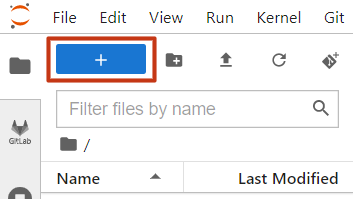
)

2. From the launcher, select `Xpra Desktop`.

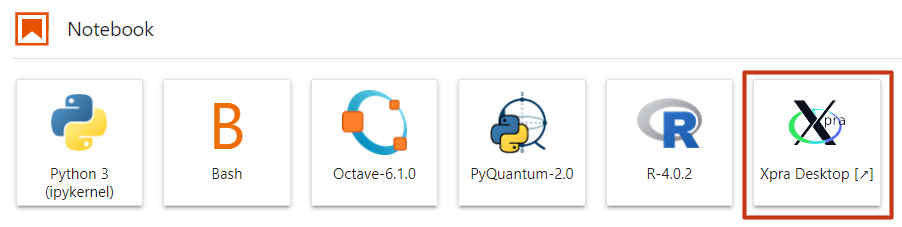

3. When Xpra Desktop has loaded, execute the following code blocks. You will see the GUI windows in your desktop where they can be controlled with the mouse.

> Note: Because of the remote access, the registration of mouse inputs may be slow.

> Note: If you want to close the program, select `Close` from the `File` context menu or click the "X" button *twice!*

*Graph To H-Matrix (draw a graph and generate the Hamiltonian):*

In [ ]:
import os, sys
_dir = os.path.abspath('.tsp')
if _dir not in sys.path:
    sys.path.append(_dir)

In [ ]:
import GraphToHMatrix
import os
from tkinter import *

if os.environ.get('DISPLAY','') == '':
    print('No display found. Using :0.0')
    os.environ.__setitem__('DISPLAY', ':0.0')

root = Tk()
window = GraphToHMatrix.GraphToHMatrix(root)
root.mainloop()

*Path Visualizer (takes a results file from the quantum annealer as input to draw the calculated paths):*

In [ ]:
import PathVisualizer
import os
from tkinter import *

if os.environ.get('DISPLAY','') == '':
    print('No display found. Using :0.0')
    os.environ.__setitem__('DISPLAY', ':0.0')

root = Tk()
window = PathVisualizer.PathVisualizer(root)
root.mainloop()

### Option 2: Entering coordinates manually

Enter your vertices as tuples (x, y) and provide a filename for saving the Hamilton matrix.

In [ ]:
import sys
import os

# ENTER POINTS HERE
nodes = [(327, 74),
         (265, 162),
         (396, 237),
         (205, 59),
         (133, 67),
         (133, 265)]
# ADJUST SCALING FACTOR (Default: 1%)
scaling = 0.01
# -------------------------------------------------------------------------------------------------------------------------------------------
filename = input("Enter filename for saving:")
if os.path.exists(os.path.join(os.getcwd(), filename)):
    confirm = input("File {0} already exists; are you sure you want to overwrite it? (y/n)".format(filename)).lower()
    if confirm == "n" or confirm == "no":
        sys.exit()

# Calculate distances
distances = {}
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        point1 = nodes[i]
        point2 = nodes[j]
        d = float("{:.2f}".format(((point2[0]-point1[0])**2 + (point2[1]-point1[1])**2)**0.5*scaling))
        distances["q" + str(i) + "q" + str(j)] = d
        distances["q" + str(j) + "q" + str(i)] = d
print("Distances:", distances)

# Create helper field
counter = 0
dim = len(nodes)
field = []
for _ in range(dim):
    f = []
    for _ in range(dim):
        f.append("q"+str(counter))
        counter += 1
    field.append(f)

# Fill and save Hamiltonian
h = [[0.0 for x in range(dim**2)] for y in range(dim**2)]
# Diagonal
for i in range(len(h)):
    h[i][i] = -8.0
# "1 entry/row and 1 entry/column is allowed" rule
for i in range(len(field)):
    for j in range(len(field[i])):
        # Iterate row
        for k in field[i][j+1:]:
            index = str(field[i][j]+k).split("q")[1:]
            h[int(index[0])][int(index[1])] = 8.0
        # Iterate column
        for k in range(len(field)):
            if k > i:
                index = str(field[i][j]+field[k][j]).split("q")[1:]
                h[int(index[0])][int(index[1])] = 8.0
# "distances" rule
for i in range(len(field)):
    for j in range(len(field[i])):
        for k in range(len(field)):
            if k == i:
                continue
            field1 = int(field[i][j][1:])
            field2 = int(field[k][(j+1) % len(field[i])][1:])
            if field1 < field2:
                h[field1][field2] = float("{:.1f}".format(distances["q"+str(i)+"q"+str(k)]))
            else:
                h[field2][field1] = float("{:.1f}".format(distances["q"+str(i)+"q"+str(k)]))

content = ""
for i in range(len(h)):
    for j in range(len(h[i])):
        content += str(h[i][j]) + " "
    content = content[:-1]
    if i != len(h) - 1:
        content += "\n"

try:
    f = open(filename, "w")
    f.write(content)
    f.close()
except OSError:
    print("Invalid filename!")
    sys.exit()

print("Saving complete!")

### Option 3: Download .exe from TSP Quantum

The above tool can be executed locally as a standalone `.exe`-file. Visit [TSP Quantum](https://tsp-quantum.netlify.app/), navigate to "Downloads" and select the ones you need.

## Experimental results

When it comes to evaluating the performance of quantum algorithms, this often poses a problem because of the inherent non-deterministic nature of this method. Due to the work with quantum states, there is always a portion of randomness involved. In the following sections, we therefore explore how efficient solving the Traveling Salesman Problem on quantum computers really is and how we can improve on this performance.

The first problem emerges when trying to quantify TSPs, the underlying mathematical problem. In order to be comparable, a uniform benchmark for graphs of arbitrary size is needed. One way to address this issue is to use graphs in the shape of regular polygons to test the quantum algorithm, starting with a triangle (since it is the simplest shape with a valid Hamiltonian cycle) up to an octagon:

<div align="center">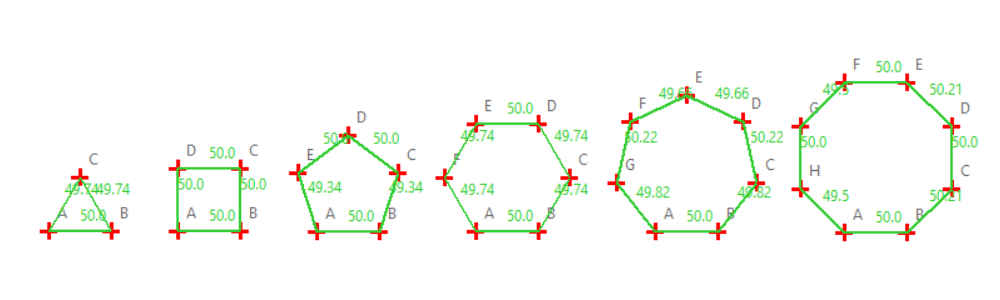</div>

Here, regular polygons with an edge length of 50 units each were used; the coordinates of the corner points can be calculated using e.g. a graphing calculator. These shapes are then converted to the respective Hamiltonian matrices, scaling the costs to 1% (0.5) and the coefficients to 8. For example, the triangle transforms into the following:

$$H=\begin{bmatrix}-8.0 & 8.0 & 8.0 & 8.0 & 0.5 & 0.5 & 8.0 & 0.5 & 0.5 \\ 0.0 & -8.0 & 8.0 & 0.5 & 8.0 & 0.5 & 0.5 & 8.0 & 0.5 \\ 0.0 & 0.0 & -8.0 & 0.5 & 0.5 & 8.0 & 0.5 & 0.5 & 8.0 \\ 0.0 & 0.0 & 0.0 & -8.0 & 8.0 & 8.0 & 8.0 & 0.5 & 0.5 \\ 0.0 & 0.0 & 0.0 & 0.0 & -8.0 & 8.0 & 0.5 & 8.0 & 0.5 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -8.0 & 0.5 & 0.5 & 8.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -8.0 & 8.0 & 8.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -8.0 & 8.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -8.0\end{bmatrix}$$

Using this structure, two problem sets were created: *Simple problems* where the costs are emitted (so the annealer's only task is to find a valid tour) and *complex problems* with the costs of the edges included. A major advantage of using polygons is that since the shortest path is always around the edges, the optimal cost can be easily calculated beforehand using this formula, given that <i>C<sub>n</sub></i> is the cost function for a polygon with *n* corners:

$$\min C_{n}\left(q\right)=-8n+0.5n=-7.5n$$

Now, the test cases are ready to be fed to the quantum annealer. But before performing the actual benchmark, we have to tune the hyperparameters, i.e. the static parameters that impact the algorithm performance and do not get changed during the calculations. The ones most important to our problem are `chain_strength` and `annealing_time`. According to the [Reference Documentation](https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/generated/dwave.system.composites.EmbeddingComposite.sample.html#dwave.system.composites.EmbeddingComposite.sample), `chain_strength` represents the "coupling strength between qubits that form a chain" on the QPU, meaning the magnitude of the magnetic fields that function as couplers forcing qubits to assume identical values. The prevailing rule of thumb states that the chain strength should equal 25% of the Hamiltonian's largest entry (often referred to as the *relative chain strength*). However, this need not always be the case.

To examine what the optimal chain strength is and how it depends on the problem size, each polygon's Hamiltonian was passed to the quantum annealer using 10 different, randomly generated embeddings each and incrementing the relative chain strength from 10% to 100% in steps of 5%. The following interactive gallery shows the results, where each graph denotes the success rate (i.e. the proportion of 500 reads that yields a solution with the optimal energy) depending on the relative chain strength:

In [ ]:
%%capture
%matplotlib inline
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json, requests

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
rel_chain_strengths = [i/100 for i in range(10, 105, 5)]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Chain strengths")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
relative_yscale = False


def change_plot(n):
    for i in range(2):
        axs[i].clear()
        figure_data = data["chain_strength_results"][n-3+i*6]
        success_rates = figure_data["data"]
        colors = plt.cm.cividis(np.linspace(0, 1, len(success_rates)))
    
        axs[i].set_title(figure_data["title"])
        axs[i].set_ylim([0.0, 1.0])
        axs[i].set_ylabel("Success rate")
        axs[i].set_xlabel("Relative chain strength")
        c = 0
        for axis in success_rates:
            axs[i].plot(rel_chain_strengths, axis, marker="x", color=colors[c])
            c += 1
    fig.canvas.draw()
    display(fig)

In [ ]:
interact(change_plot, n=widgets.IntSlider(min=3, max=8, step=1, value=3, description="Number of cities", style={'description_width': 'initial'}));

The results show that the optimal chain strength (represented by the maximum of the graphs) begins at 40% and grows with each added city. The scatter of the individual graphs shows how much embedding affects the performance of the quantum annealer. Also noticeable is the significant falloff in the performance between simple and complex problems after ```n = 4``` included. While for the simple problems the annealer was able to find at least one correct solution for each problem size, for the complex problems with ```n > 6``` cities, however, no single route with the optimal energy was found. This gives a first picture of where the limitations are.

A similar procedure was applied for the optimization of ```annealing_time``` which sets the time the qubits are allowed to anneal to their optimal energy state before reading them and causing the superposition to collapse. The default value is set to 20μs; in theory, the greater the duration, the greater the expected proportion of correct results. To test this hypothesis, the same problem classes were calculated using the best-performing embeddings and chain strengths derived from the previous experiment, each with 20 different annealing times distributed logarithmically on a scale from 1μs to 2000μs (the physical limitations of the D-Wave quantum annealer). The success rates are presented in the diagrams below:

In [ ]:
%%capture
%matplotlib inline
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json, requests

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
annealing_times = np.clip(np.geomspace(1.0, 2000, 20), 1.0, 2000)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Annealing times")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
relative_yscale = False


def change_plot(n):
    for i in range(2):
        axs[i].clear()
        figure_data = data["annealing_time_results"][n-3+i*6]
        success_rates = figure_data["data"]
        colors = plt.cm.cividis(np.linspace(0, 1, len(success_rates)))
    
        axs[i].set_title(figure_data["title"])
        axs[i].set_ylim([0.0, 1.1])
        axs[i].set_xscale("log")
        axs[i].set_ylabel("Success rate")
        axs[i].set_xlabel("Annealing time [μs]")
        axs[i].plot(annealing_times, success_rates, marker="x", color=colors[0])

    fig.canvas.draw()
    display(fig)

In [ ]:
interact(change_plot, n=widgets.IntSlider(min=3, max=8, step=1, value=3, description="Number of cities", style={'description_width': 'initial'}));

Since the graphs are growing mostly linearly, the assumption that a higher annealing time results in a higher success rate has been confirmed for the most part, while the performance difference between 1μs and 2000μs is most significant in the middle and most shallow at the edges of `n`'s range. The previously observed falloff between the simple and complex problem class is also present here. Looking at the data, it can be seen that in contrast to the previous experiment, for the complex problem with `n = 7`, the correct solution could be found at least once with an annealing time greater than ≈36.6μs while `n = 8` from the same problem set remains unsolved.

After the hyperparameters have been optimized, it's time to evaluate the overall effectiveness of the quantum solution method. To achieve this, every polygon size of both problem sets was evaluated by the state-of-the-art *D-Wave Advantage* (Pegasus architecture, 5640 qubits) and the older *D-Wave 200Q* (Chimera architecture, 2048 qubits) systems with 10 random generated embeddings each. As a comparison to traditional computing, the problems were also submitted to a *Simulated Annealing* algorithm, which is a widely used heuristic approach to optimization problems that changes the parameters of a problem through random permutations and uses a cooling function to decide whether to keep or discard these<sup>9)</sup>. A full explanation would go beyond the scopes of this course, but if you want to learn more about the procedure in detail, you can read about its applications in TSPs [here](https://www.fourmilab.ch/documents/travelling/anneal/).

Finally, the following graphs present the results of the different approaches in comparison. Since we're not after relative performance comparisons over a spectrum of values like in the experiments before, we'll only keep the best solution yielded by the reads and calculate difference to the optimal solution instead of the success rate. The first group shows these energy deltas and the second the times needed for solving. Therefore, in both cases, lower values are better. The bars indicate the arithmetic mean of 10 experimental results while the error bars show the standard deviation, meaning the average dispersion:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json, requests

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
group = data["benchmark_results"][0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(group["title"])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
colors = plt.cm.cividis([0.1, 0.9])

for i in range(3):
    graph = group["graphs"][i]
    raw_points = graph["data"]

    means_simple = [np.mean(raw_points[i]) for i in range(0, 6)]
    means_complex = [np.mean(raw_points[i]) for i in range(6, 12)]
    stddev_simple = [np.std(raw_points[i]) for i in range(0, 6)]
    stddev_complex = [np.std(raw_points[i]) for i in range(6, 12)]

    labels = list(range(3, 9))
    x_pos = np.arange(len(labels))

    # Build the plot
    axs[i].bar(x_pos - 0.2, means_simple, yerr=stddev_simple, align='center', width=0.4, color=colors[0], ecolor='black', capsize=5, label="Simple problem")
    axs[i].bar(x_pos + 0.2, means_complex, yerr=stddev_complex, align='center', width=0.4, color=colors[1], ecolor='black', capsize=5, label="Complex problem")
    z = np.polyfit(x_pos, means_complex, 1)
    p = np.poly1d(z)
    axs[i].plot(x_pos + 0.2, p(x_pos), color="goldenrod", linestyle="dashed", alpha=0.7, label="Trend line")
    if i == 0:
        axs[i].set_ylabel('Energy difference to optimum ($\Delta E$)')
    axs[i].set_ylim([-1, 15])
    axs[i].set_xticks(x_pos)
    axs[i].set_xticklabels(labels)
    axs[i].set_title(graph["title"])
    axs[i].legend()

plt.show()

As you can see, the deviation varies across problem sizes for the quantum annealers, whereas for Simulated Annealing, it is always at 0, meaning that the algorithm always finds the best solution. The same plot is made for the times needed for calculation:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json, requests

data = json.loads(requests.get("https://tsp-quantum.netlify.app/docs/TSPQ_data.json").text)
group = data["benchmark_results"][1]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(group["title"])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
colors = plt.cm.cividis([0.1, 0.5])

for i in range(3):
    graph = group["graphs"][i]
    raw_points = graph["data"]

    means_simple = np.array([np.mean(raw_points[i]) for i in range(0, 6)]) * 0.001
    means_complex = np.array([np.mean(raw_points[i]) for i in range(6, 12)]) * 0.001
    stddev_simple = np.array([np.std(raw_points[i]) for i in range(0, 6)]) * 0.001
    stddev_complex = np.array([np.std(raw_points[i]) for i in range(6, 12)]) * 0.001

    labels = list(range(3, 9))
    x_pos = np.arange(len(labels))

    # Build the plot
    axs[i].bar(x_pos - 0.2, means_simple, yerr=stddev_simple, align='center', width=0.4, color=colors[0], ecolor='black', capsize=5, label="Simple problem")
    axs[i].bar(x_pos + 0.2, means_complex, yerr=stddev_complex, align='center', width=0.4, color=colors[1], ecolor='black', capsize=5, label="Complex problem")
    if i == 0:
        axs[i].set_ylabel('Computing time ($[ms]$)')
    if i < 2:
        axs[i].set_ylim([0, 200])
    axs[i].set_xticks(x_pos)
    axs[i].set_xticklabels(labels)
    axs[i].set_title(graph["title"])
    axs[i].legend()

plt.show()

This experiment immediately shows the downside of Simulated Annealing, similar to other traditional computing methods: Whereas it is able to find optimal solutions for large problem sizes, the time needed for computation is very lengthy, more than 10 minutes in most cases. The quantum annealers on the other hand are able to solve the same tasks in just fragments of a second. The newer D-Wave Advantage model is faster than the 2000Q across all problem sizes, but the computing time varies more greatly and is less consistent.

All Python files used to perform the experiments as well as the raw measurement data can be accessed at [the project's GitHub repository](https://github.com/Totemi1324/TSPquantum) and under the *Downloads* section of [TSP Quantum](https://tsp-quantum.netlify.app/).

## Where are the constraints?

Although the unbeatable speed of this quantum approach makes it very attractive, it also has some major limitations. Some of them are posed by the simple state of today's technology and are likely to be overcome by future advancements in the field of quantum computing. Since a graph of *n* nodes is first converted to a Tour Matrix of <i>n<sup>2</sup></i> elements and then to a Hamiltonian of <i>(n<sup>2</sup>)<sup>2</sup></i> elements, the number of qubits and connections needed rises quartically, i.e. by an exponent of four. Analogous to traditional computing, you could characterize the *complexity* of the quantum algorithm as:

$$O\left(n\right)\approx n^4$$

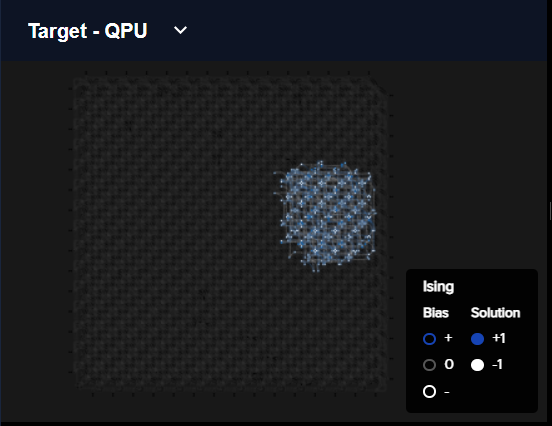

As the number of interconnected qubits rises, the number of physical qubits that need to be combined to logical qubits increases, causing the probability of false results to grow exponentially. This is why `n = 8` is approximately the limit of what the current D-Wave Advantage system can solve, as each qubit is connected to 15 others only. With each city added, the embedding also becomes larger, until eventually all the space on the QPU is used up. The figure on the left shows the space the embedding of the problem size `n = 8` takes up on the QPU, working with chains that span 8-9 qubits in length. However, due to increasing computing capacity and more complex architectures, this limitation will likely become increasingly irrelevant in the future.

The *matrix density*, meaning the proportion of matrix elements that are not zeros, also plays a role in computing efficiency. The sparser the Hamiltonian, i.e. the fewer chains are needed relative to the problem size, the easier it is for the quantum computer to solve the QUBO problem. Since the matrices produced by this quantum TSP algorithm are relatively dense, the performance limit is reached with smaller problem sizes than usual. This problem is far more relevant since it is not yet foreseeable whether the accuracy problems of quantum annealers will be solved by scaling alone.

### A solution approach: Controlling the embedding

When submitting problems to the QPU, the embedding is generated automatically by D-Wave Ocean to save time, especially in the case of larger problems. However, this is a complex optimization task as well which is why algorithms are likely to not find the best solution. If we wanted to maximize the efficiency, it therefore would be theoretically possible to manually embed the QUBO problem and to set each qubit and connection by hand [using a dictionary](https://docs.ocean.dwavesys.com/en/stable/concepts/embedding.html):

In [ ]:
from dwave.system import FixedEmbeddingComposite

sampler = FixedEmbeddingComposite(DWaveSampler(solver={'qpu': True}),
                                  embedding={'s0': [0, 4, 7], 's1': [2], 's2': [3, 6]})

This task however requires not only a large amount of further mathematical calculations, but also an intricate and founded knowledge of the QPU topology. The process is time-consuming and has to be repeated for each individual problem size, making it only worthwhile for some small problems.

## Further possible improvements

The presentation and evaluation of the method is completed; however, it should be considered more as a basis for further algorithmic approaches of this kind and can be further optimized and extended with a few adjustments.

Since TSP solutions are closed loops and visit every city, the starting point can be set arbitrarily. So in theory, if we take this decision away from the quantum annealer and set the starting point to, say, `A`, the first row and column of the Tour matrix can be omitted, since this city is guaranteed not to be visited in the rest of the path:

<div align="center">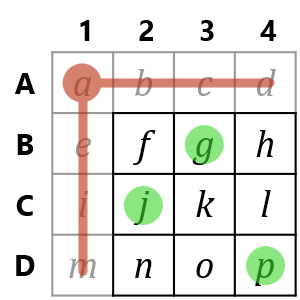</div>

In addition, the cost function needs to be adjusted so the path from `A` to `B`, `A` to `C` etc. is only dependent on the second node visited. This approach reduces the size of the Tour Matrix by 1, meaning the number of cities the annealer can find a solution for can be increased by 1 beyond its normal computing capability. However, these and other optimizations are only worthwhile in the long term if they can actually reduce the number of non-zero entries in the Hamiltonian.

To make the algorithm more applicable for real-life situations, it would also be possible to extend it beyond the scope of the traditional Traveling Salesman Problem for *incomplete graphs* (where not all nodes are interconnected) and *directed graphs* (where certain edges can only be traversed in one direction or have different costs depending on the traversing direction):

<div align="center" style="margin-bottom: 20px">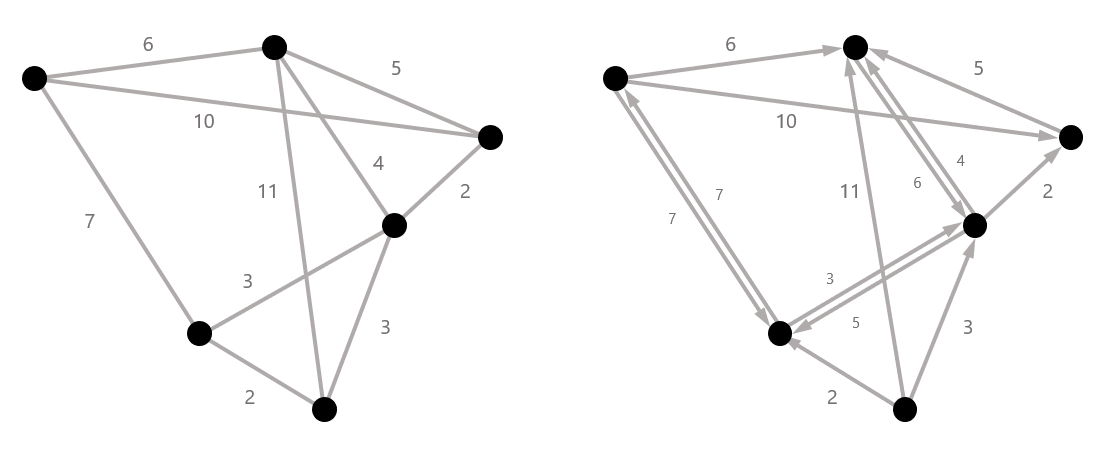<br><i>Examples of an incomplete graph (left) and a directed graph (right)</i></div>

If a connection between a pair of cities doesn't exists (for example because of a road network layout), the quantum annealer has to be discouraged at all costs from incorporating it in the solution. To represent a non-existent edge, you therefore could assign a massive punishment to it so that the lowest cost is never reached if it's part of the tour. In mathematical literature, this is commonly expressed with an "infinity" symbol, but in our case, a high integer number is more applicable.

$$H=\begin{bmatrix}-2 & 2 & 2 & 2 & 2 & \infty & 0 & \infty & \cdots & 4 \\ 0 & -2 & 2 & 2 & \infty & 2 & \infty & 0 & \cdots & 0 \\ 0 & 0 & -2 & 2 & 0 & \infty & 2 & \infty & \cdots & 4 \\ 0 & 0 & 0 & -2 & \infty & 0 & \infty & 2 & \cdots & 2 \\ 0 & 0 & 0 & 0 & -2 & 2 & 2 & 2 & \cdots & 3.6 \\ 0 & 0 & 0 & 0 & 0 & -2 & 2 & 2 & \cdots & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -2 & 2 & \cdots & 3.6 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -2 & \cdots & 2 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & -2\end{bmatrix}\Rightarrow\begin{bmatrix}-2 & 2 & 2 & 2 & 2 & 100 & 0 & 100 & \cdots & 4 \\ 0 & -2 & 2 & 2 & 100 & 2 & 100 & 0 & \cdots & 0 \\ 0 & 0 & -2 & 2 & 0 & 100 & 2 & 100 & \cdots & 4 \\ 0 & 0 & 0 & -2 & 100 & 0 & 100 & 2 & \cdots & 2 \\ 0 & 0 & 0 & 0 & -2 & 2 & 2 & 2 & \cdots & 3.6 \\ 0 & 0 & 0 & 0 & 0 & -2 & 2 & 2 & \cdots & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -2 & 2 & \cdots & 3.6 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -2 & \cdots & 2 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & -2\end{bmatrix}$$

To represent different costs at different traversing directions in a directed graph, you only have to differentiate between the order the nodes can be visited when formulating the QUBO equation. In the example below, the cost function has different values depending on whether the path leads from A to C or from C to A:

<div align="center">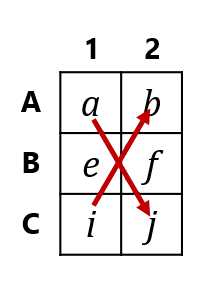</div>

$$\Rightarrow f\left(a,b,...,i,j\right)=...+3aj+5ib+...$$

The previous method can be applied to the case when a connection exists only in one direction: The other direction is assigned a high cost. It should be noted, however, that in the case of incomplete and directed graphs, the quantum annealer can only output a valid solution if a Hamiltonian cycle actually exists.

## Closing thoughts

With new milestones being achieved every year, quantum computing is a rapidly evolving technology that will have a major impact on our lives. It constitutes a very promising approach for the future, which is why further research on quantum algorithms for the Traveling Salesman Problem and other tasks is definitely worthwhile.

Nevertheless, it is important to recognize the limitations as well. Until this method can be applied to problems relevant to everyday life and business (~50-100 cities), much progress needs to be made. However, contrary to its (yet) limited capacity and its error rate, the quantum approach has a major potential to be used in real life, since in industry, in most cases, not necessarily the best but a good solution is needed and the speed with which it is found is much more important than its accuracy. Solving the TSP with quantum annealers therefore represents a great opportunity that can significantly accelerate manufacturing, logistics and research processes in the future.

### Thank you notes

I would like to sincerely thank everyone who supported me in this research, especially [D-Wave Systems Inc.](https://www.dwavesys.com/) and the [Jülich Supercomputing Centre](https://www.fz-juelich.de/de/ias/jsc).

Special thanks go to Dennis Willsch and Kristen Michielsen at the JSC for their generous support, guidance and coordination.

Thanks also to René Grünbauer from Gymnasium der Regensburger Domspatzen, who made the project possible through his excellent ideas.

### References

1) https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland, accessed: 10.03.2022
2) https://en.wikipedia.org/wiki/Travelling_salesman_problem, accessed: 10.03.2022
3) Heena Rijhwani, *Optimization*, (2020), https://medium.com/analytics-vidhya/optimization-acb996a4623c, accessed: 10.03.2022
4) https://en.wikipedia.org/wiki/Vector_(mathematics_and_physics), accessed: 18.03.2022
5) M. Willsch, D. Willsch, K. Michielsen. *Lecture notes: Programming Quantum Computers*. arXiv: 2201.02051 (2022), accessed: 19.03.2022
6) Fiona H, *New QPU Solver: Advantage Performance Update*, (2021), https://support.dwavesys.com/hc/en-us/articles/4410049473047-New-QPU-Solver-Advantage-Performance-Update, accessed: 20.03.2022
7) Fig. 2, C. Gonzales Calaza, D. Willsch, K. Michielsen. *Garden optimization problems for benchmarking quantum annealers*. arXiv: 2101.10827 (2021), accessed: 20.03.2022
8) https://docs.ocean.dwavesys.com/projects/system/en/stable/index.html, accessed: 21.03.2022
9) https://en.wikipedia.org/wiki/Simulated_annealing, accessed: 12.05.2022